# Modeling

With our data cleaned and prepped, we're now ready to dive into the modeling phase. To predict restaurant rating success, we're trying out these models:

1. [Logistic Regression](#logistic-regression)
    - [RandomizedSearchCV](#logistic-regression)
    - [GridSearchCV](#GridSearchCV) 
    - [Logistic Regression-L2](#Logistic-regression-L2)
    - [Cross-Validation](#Cross-Validation)
    - [Classification Report](#ClassificationReport)
    - [Confusion Matrix](#Confusion-Matrix)
    - [ROC](#ROC)
    - [Precision-Recall Curve](#Precision-Recall-Curve)
    - [Feature Coefficients](#Feature-Coefficients)

2. [Random Forest](#Random-forest) 
    - [Random Forest Classification report](#Random-Forest-Classification-report) 

    - [Feature_importances & Model Refinement with Random Forest](#Feature_importances-&-Model-Refinement-with-Random-Forest) 
3. [Gradient Boosting (GBM)](#Gradient-boosting-gbm)
    - [PipeLine for  GradientBoostingClassifier](#PipeLine-for-GradientBoostingClassifier)
4. [XGBoost](#Xgboost) 
    - [PipeLine for XGboost](#PipeLine-for-XGboost) 
    - [XGboost Confusion_matrix](#XGboost-Confusion_matrix)
    - [Feature Mean Differences Analysis](#Feature-Mean-Differences-Analysis)
    - [SHAP Analysis for XGBoost](#SHAP-Analysis-for-XGBoost)
5. [Conclusion](#Conclusion)

Let's load our cleaned and pre-processed data 

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_b = pd.read_csv('data/Cleaned_Data.csv')


In [ ]:
**Model Training**
Here, describe the process you followed for training the logistic regression model, hyperparameters chosen, and any challenges you faced.

**Preliminary Results**
Show initial results or metrics for this model.


# logistic-regression

In order to enhance the performance of our Logistic Regression model, we employ hyperparameter tuning. The technique used is `RandomizedSearchCV`, which randomly samples from a distribution of hyperparameters over a specified number of iterations. This approach can be more efficient than exhaustive grid search.

**Hyperparameters Considered:**
1. **C:** The inverse regularization strength. Smaller values specify stronger regularization. We're sampling from a continuous uniform distribution between 0 and 4.
2. **Penalty:** Used to specify the norm used in the penalization (`l1` or `l2`).
3. **Solver:** Algorithm to use in the optimization problem (`liblinear` and `saga` which supports both `l1` and `l2` regularization).

**Model Training:**
We've set the number of iterations for randomized search to 500, with a 5-fold cross-validation. This means the entire dataset will be split into 5, and the model will be trained and validated 5 times, each time using a different subset as the validation set.

# RandomizedSearchCV

In [103]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the hyperparameters and their distributions
param_dist = {
    'C': uniform(loc=0, scale=4),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear','saga' ]
}

# Create the model
log_reg = LogisticRegression()

# Set up randomized search
random_search = RandomizedSearchCV(log_reg, param_distributions=param_dist, n_iter=500, cv=5, random_state=42)

# Fit the model
random_search.fit(X_train_scaled, y_train)

# Print the best parameters
print(random_search.best_params_)

# Evaluate the model with the best hyperparameters on the test set
print(random_search.score(X_test_scaled, y_test))


{'C': 2.5907604821654493, 'penalty': 'l1', 'solver': 'liblinear'}
0.695893237057572


While `RandomizedSearchCV` offers a broader view of the hyperparameter space, `GridSearchCV` helps in a more exhaustive search over a specified parameter grid. Given the best parameters found from the randomized search:


we're now going to conduct a more refined search around these values using `GridSearchCV`.

**Hyperparameters Grid:**
1. **C:** The inverse of regularization strength. Values are chosen around the result from the randomized search.
2. **Penalty:** Norm used in the penalization (`l1` or `l2`).
3. **Solver:** Algorithm to use in the optimization problem. We continue with `liblinear` and `saga` as they support both `l1` and `l2`.

**Model Training:**
We employ a 5-fold cross-validation with this grid search as well.

# GridSearchCV

In [140]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 2.15, 2.59, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear','saga']
}

# Create the model
log_reg = LogisticRegression()

# Set up grid search
grid_search = GridSearchCV(log_reg, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print(grid_search.best_params_)

# Evaluate the model with the best hyperparameters on the test set
print(grid_search.score(X_test_scaled, y_test))


{'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.6957642963058475


**Best Hyperparameters from Grid Search:**
The results from `GridSearchCV` will give us the most optimal combination of hyperparameters from the specified grid. 

**Model Evaluation on Test Set:**
Post hyperparameter tuning, we evaluate the logistic regression model on the test dataset to understand its performance with the new parameters.


With the optimal hyperparameters determined from `GridSearchCV`, we apply and evaluate the Logistic Regression model.

**Data Preparation:**
1. **Splitting:** Data is split into training (70%) and testing (30%) sets, ensuring the split reflects the distribution of the `Rating_Success` target variable.
2. **Scaling:** We scale our features using the `StandardScaler` to ensure better performance and convergence for the logistic regression model.

**Model Training:**
The logistic regression model is implemented with an \(L_2\) penalty (ridge regression). The `saga` solver and \(C=100\) are parameters decided from our prior hyperparameter tuning phase.

**Model Evaluation:**
After training, we evaluate the model's accuracy on both the training and test datasets using the scaled data since the model was trained with it.


# Logistic-regression-L2

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'Rating_Success' is your target variable
X = df_b.drop(columns=['Rating_Success'])
y = df_b['Rating_Success']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating and fitting the logistic regression model with L2 penalty
log_reg_l2 = LogisticRegression(penalty='l2', solver='saga', C=100)
log_reg_l2.fit(X_train_scaled, y_train)


# Evaluating the model on the Sacaled train data
train_score = log_reg_l2.score(X_train_scaled, y_train)
print(f'Train Accuracy: {train_score}')


# Evaluating the model on the Scaled test data
test_score = log_reg_l2.score(X_test_scaled, y_test)
print(f' Test Accuracy: {test_score}')


Train Accuracy: 0.7065097259062776
 Test Accuracy: 0.6957642963058475


**Model Evaluation Results:**
- **Train Accuracy (Scaled Data):** 0.7065
- **Test Accuracy (Scaled Data):** 0.6958

The results show that the model achieves around 70.65% accuracy on the training data and 69.58% on the test data. The minor drop in accuracy from training to test data suggests that our model is generalizing well to unseen data without signs of overfitting.


# Cross-Validation

### Cross-Validation of the Logistic Regression Model

To ensure the stability and reliability of our logistic regression model, we perform cross-validation. This process involves splitting the training dataset into multiple subsets (folds) and training/testing the model multiple times, once for each fold. This helps assess the model's performance on different portions of the data, ensuring that our model isn't just fitting well to one specific subset.



In [160]:
from sklearn.model_selection import cross_val_score

# Get cross-validation scores
cv_scores = cross_val_score(log_reg_l2, X_train_scaled, y_train, cv=5)

# Print the scores and the mean
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())


Cross-validation scores: [0.70106368 0.71377262 0.7033711  0.6941144  0.69812103]
Mean CV score: 0.7020885648990507


### Methodology:

1. **Model Used**: L2-penalized Logistic Regression (`log_reg_l2`).
2. **Number of Folds**: 5.

### Results:

| Fold | Accuracy |
|------|----------|
| 1    | 0.7011   |
| 2    | 0.7138   |
| 3    | 0.7034   |
| 4    | 0.6941   |
| 5    | 0.6981   |

**Average Cross-Validation Score**: 0.7021

This average score indicates how well our model is expected to perform on unseen data. The consistency across folds suggests that our model is stable and not overfitting to a specific portion of the training data.

--------------------------------------




# ClassificationReport

-----------------

## Classification Report for Logistic Regression Model

After training our L2-penalized Logistic Regression model, we evaluate its performance on the test set. The classification report provides insights into the precision, recall, and F1-score of the model for each class, along with macro and weighted averages.

### Key Metrics:

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall**: The ratio of correctly predicted positive observations to all the actual positives.
- **F1-Score**: The weighted average of Precision and Recall. It's a good metric to consider if you have an uneven class distribution.

In [269]:
from sklearn.metrics import classification_report

# Print the classification report
y_pred = log_reg_l2.predict(X_test_scaled)
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.71      0.77      0.74      8617
           1       0.68      0.60      0.64      6894

    accuracy                           0.70     15511
   macro avg       0.69      0.69      0.69     15511
weighted avg       0.69      0.70      0.69     15511





### Results:

| Class | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| 0     | 0.71      | 0.77   | 0.74     |
| 1     | 0.68      | 0.60   | 0.64     |

**Overall Accuracy**: 0.70

**Macro Average (Precision, Recall, F1)**: 0.69, 0.69, 0.69

**Weighted Average (Precision, Recall, F1)**: 0.69, 0.70, 0.69

### Interpretation:

1. **Class 0 (Negative Class)**: Our model has a precision of 0.71, meaning that 71% of the instances predicted as class 0 are truly class 0. The recall of 0.77 indicates that the model correctly identified 77% of all actual class 0 instances.
2. **Class 1 (Positive Class)**: The model exhibits a precision of 0.68 and a recall of 0.60. This means that 68% of the instances predicted as class 1 are true class 1 instances, and the model captures 60% of all actual class 1 instances.

The model's overall accuracy is 0.70, suggesting it correctly predicts 70% of the test instances. The close values of precision, recall, and F1-score for both macro and weighted averages indicate a balanced model performance across both classes.


-----------------

# Confusion Matrix

## Confusion Matrix for the Logistic Regression Model

The confusion matrix is a powerful tool for evaluating classification models by presenting the actual versus the predicted values. It's particularly useful for understanding the types of errors our model is making.

### Confusion Matrix Explained:

- **True Positives (TP)**: The model correctly predicted the positive class.
- **True Negatives (TN)**: The model correctly predicted the negative class.
- **False Positives (FP)**: The model incorrectly predicted the positive class.
- **False Negatives (FN)**: The model incorrectly predicted the negative class.



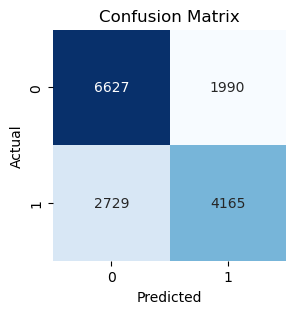

array([[6627, 1990],
       [2729, 4165]])

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = log_reg_l2.predict(X_test_scaled)
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
cm

### Key Insights:

1. **True Negatives (TN)**: 6627 instances were correctly predicted as class 0.
2. **False Positives (FP)**: The model wrongly classified 1990 instances as class 1 when they were actually class 0.
3. **False Negatives (FN)**: 2729 instances were mistakenly predicted as class 0 when they were in reality class 1.
4. **True Positives (TP)**: 4165 instances were accurately predicted as class 1.

Understanding the distribution of these values can inform us about the nature and types of mistakes the model makes. 

-----------

# ROC

## Receiver Operating Characteristic (ROC) Curve for Restaurant Ratings

The ROC curve is a graphical representation of the performance of a binary classification model. The curve is created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The area under the ROC curve (AUC) provides a measure of the model's ability to distinguish between the positive and negative classes.

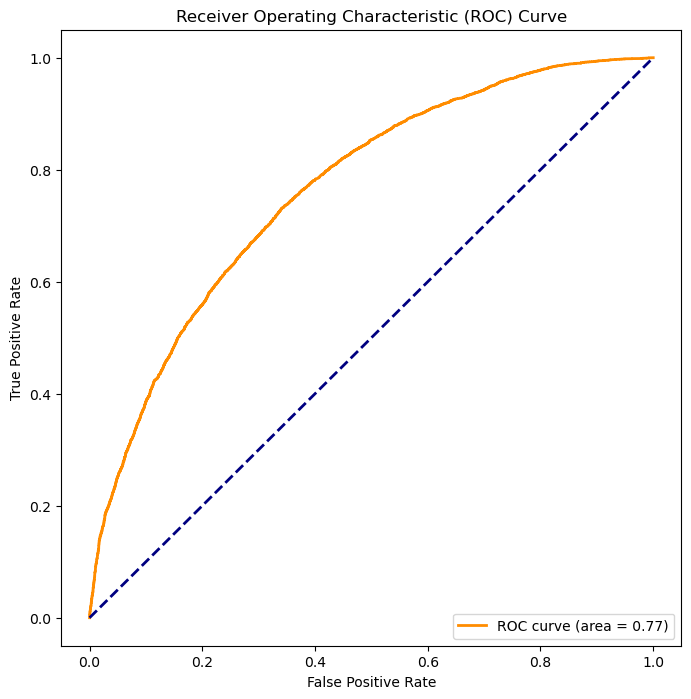

In [155]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob = log_reg_l2.predict_proba(X_test_scaled)[:,1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Interpretation of AUC = 0.77

The AUC (Area Under the Curve) value gauges the model's ability to differentiate between positive and negative samples.


- **Good Discriminative Power**: The AUC of 0.77 suggests a 77% chance that the model can correctly distinguish between positive and negative instances.

- **Better than Random**: An AUC of 0.77 surpasses the 0.5 benchmark, which is equivalent to random guessing.

- **Room for Enhancement**: Though 0.77 is commendable, refining features, trying varied algorithms, or collecting more data might boost performance.


---------

# Precision-Recall Curve 

The Precision-Recall curve is a tool used for evaluating the performance of a classification model, especially in imbalanced datasets. A higher area under the curve represents better performance.

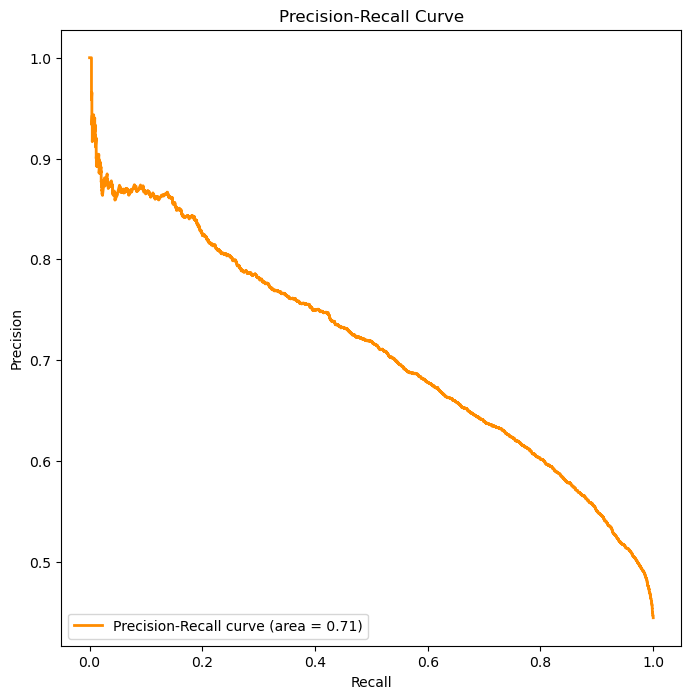

In [156]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall and plot curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8,8))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


- **Area Under the Curve (AUC)**: The AUC of 0.71 for the Precision-Recall curve is a decent score. The closer this value is to 1, the better the model is at classification.

- **Interpretation**: An area of 0.71 suggests that the model has good precision and recall for the given problem. However, there might be room for improvement.

- **Visual Insights**: The curve provides a visual representation of the trade-off between precision (y-axis) and recall (x-axis). The better the model, the closer the curve will be to the top-right corner.

# Feature Coefficients

### Analysis of Feature Coefficients from Logistic Regression
In a logistic regression model, the coefficients (or weights) attached to each feature indicate the importance of that feature in predicting the target variable. Positive coefficients increase the log odds of the response (and thus increase the probability), and negative coefficients decrease the log odds of the response (and thus decrease the probability).


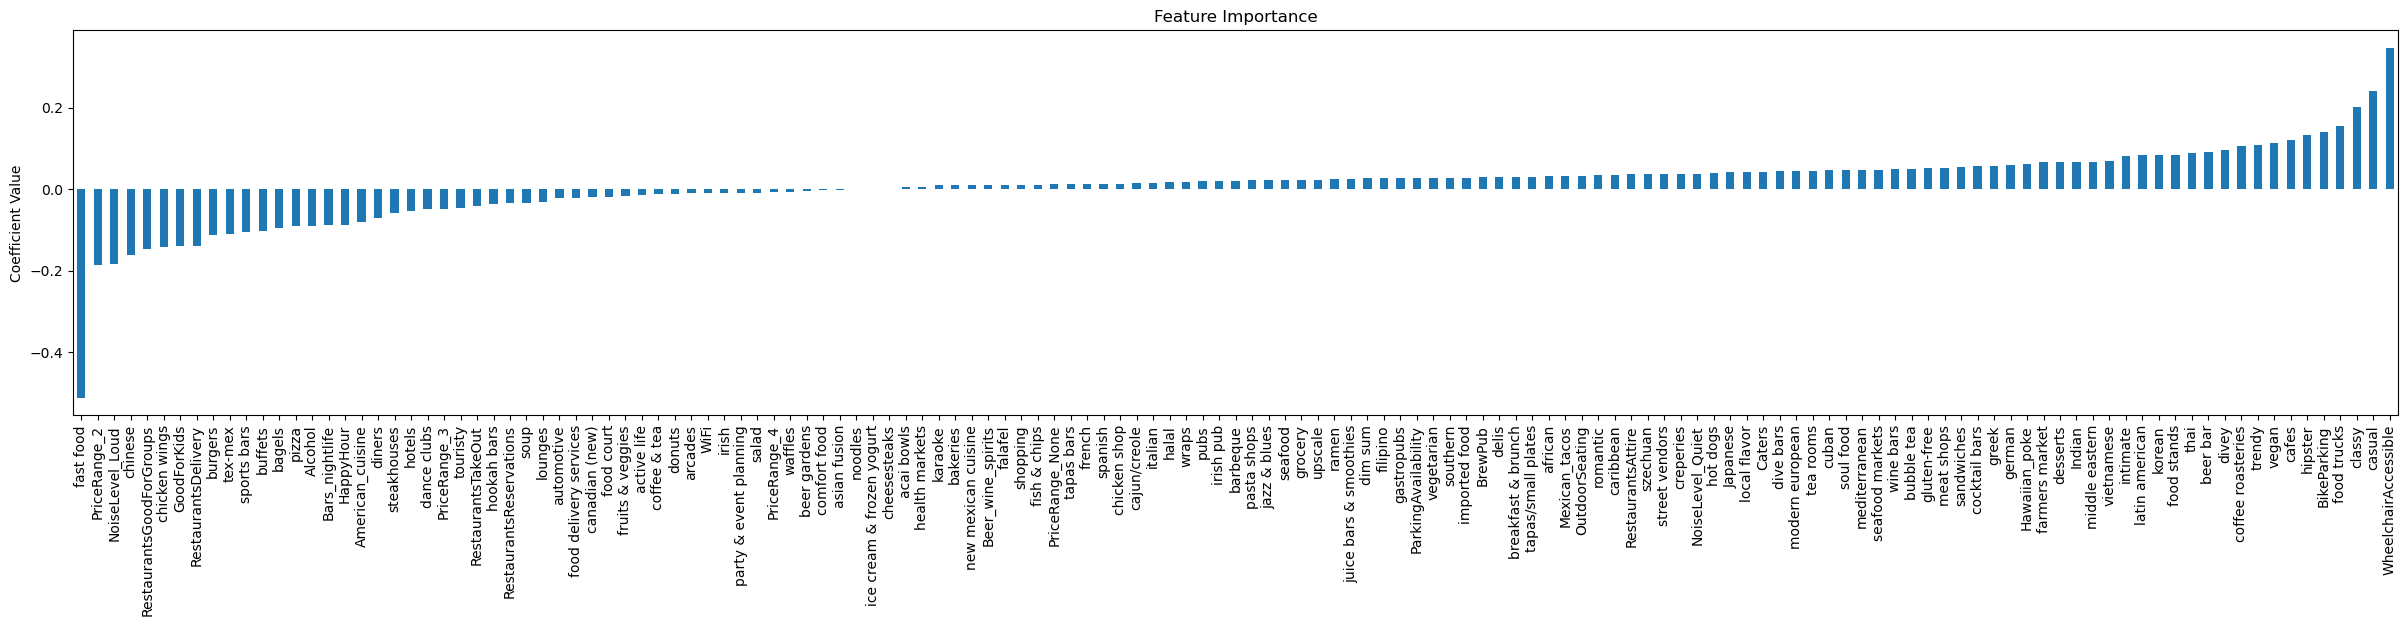

In [182]:

# Extracting coefficients
coefficients = log_reg_l2.coef_[0]
feature_names = X.columns

# Plotting
plt.figure(figsize=(30, 5))
coef_series = pd.Series(coefficients, index=feature_names).sort_values()
coef_series.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Coefficient Value')
plt.show()


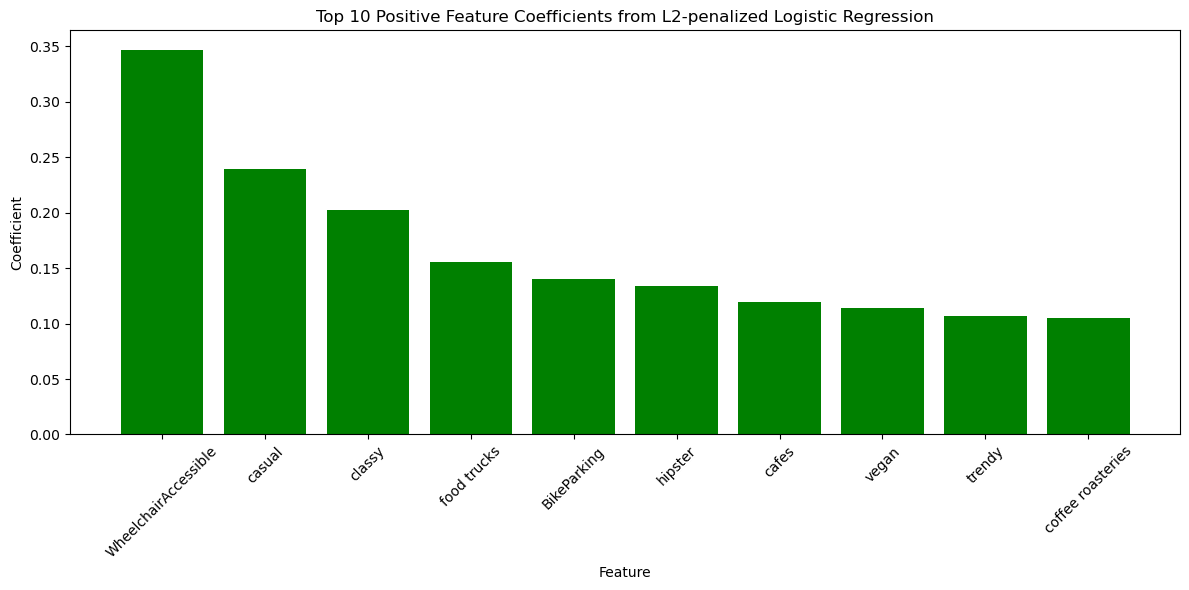

In [362]:
###### import numpy as np
import matplotlib.pyplot as plt

# Get feature names
features = X.columns

# Get coefficients and feature names
coefs = log_reg_l2.coef_[0]

# Create indices for sorting based on coefficients
sorted_idx = np.argsort(coefs)

# Separate and sort positive and negative coefficients
sorted_negative_coefs = coefs[sorted_idx][coefs[sorted_idx] < 0]
sorted_positive_coefs = coefs[sorted_idx][coefs[sorted_idx] > 0][::-1]

# Sort feature names based on the same order
sorted_features_neg = np.array(features)[sorted_idx][coefs[sorted_idx] < 0]
sorted_features_pos = np.array(features)[sorted_idx][coefs[sorted_idx] > 0][::-1]

# Select top 10 positive features and coefficients
top_10_features = sorted_features_pos[:10]
top_10_positive_coefs = sorted_positive_coefs[:10]

# Plot top 10 positive coefficients
plt.figure(figsize=(12, 6))
plt.bar(top_10_features, top_10_positive_coefs, color='green', align='center')  # Set align to 'center'
plt.title("Top 10 Positive Feature Coefficients from L2-penalized Logistic Regression")
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# You can repeat the process for the negative coefficients as well.


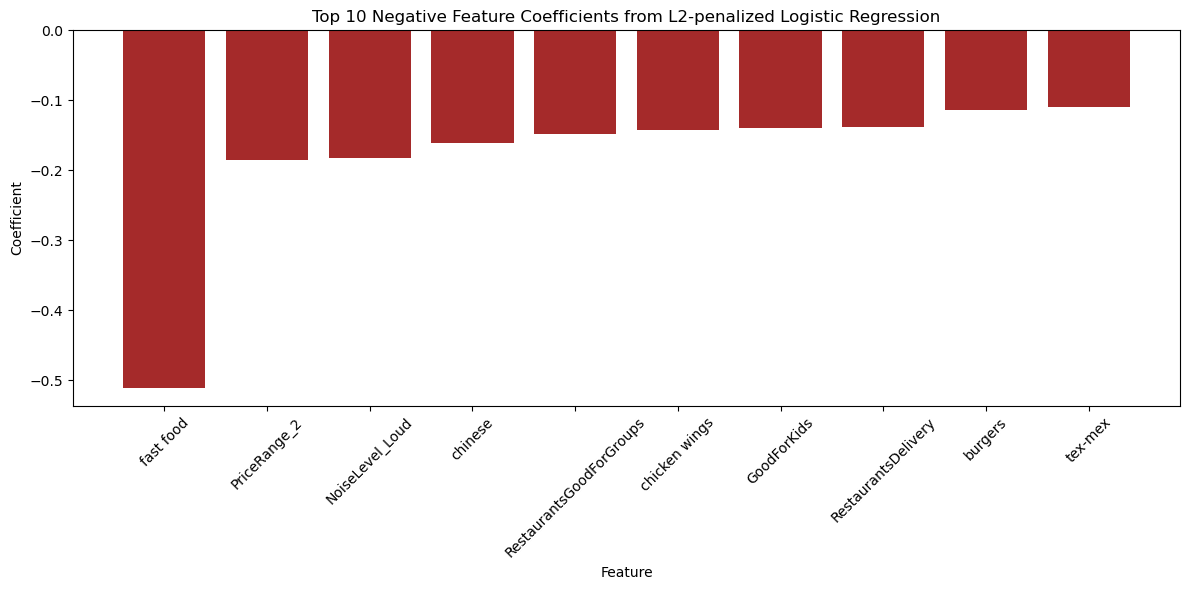

In [364]:
# Select top 10 negative features and coefficients
top_10_negative_features = sorted_features_neg[:10]
top_10_negative_coefs = sorted_negative_coefs[:10]

# Plot top 10 negative coefficients
plt.figure(figsize=(12, 6))
plt.bar(top_10_negative_features, top_10_negative_coefs, color='brown', align='center')  # Set align to 'center'
plt.title("Top 10 Negative Feature Coefficients from L2-penalized Logistic Regression")
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [76]:
# Select top 10 positive and negative coefficients
top_10_positive_coefs = sorted_positive_coefs[:10]
top_10_negative_coefs = sorted_negative_coefs[:10]

# Select top 10 positive and negative feature names
top_10_features_pos = sorted_features_pos[:10]
top_10_features_neg = sorted_features_neg[:10]

# Print top 10 positive coefficients and their features
print("Top 10 Positive Coefficients and their Features:")
for coef, feat in zip(top_10_positive_coefs, top_10_features_pos):
    print(f"{feat}: {coef}")

print("\n")  # for a newline in between

# Print top 10 negative coefficients and their features
print("Top 10 Negative Coefficients and their Features:")
for coef, feat in zip(top_10_negative_coefs, top_10_features_neg):
    print(f"{feat}: {coef}")

Top 10 Positive Coefficients and their Features:
WheelchairAccessible: 0.34708717791665983
casual: 0.23940380339782308
classy: 0.20201689320067462
food trucks: 0.1557886093503703
BikeParking: 0.1406061542754883
hipster: 0.13381160433922704
cafes: 0.11978788538233083
vegan: 0.11368822645957535
trendy: 0.10724091701068514
coffee roasteries: 0.10459566187724072


Top 10 Negative Coefficients and their Features:
fast food: -0.5108530938289159
PriceRange_2: -0.18504134773280237
NoiseLevel_Loud: -0.18240693389977444
chinese: -0.16068961777723773
RestaurantsGoodForGroups: -0.1479526197396306
chicken wings: -0.14308051014827536
GoodForKids: -0.13963373749987879
RestaurantsDelivery: -0.13853799403706826
burgers: -0.11335566521576328
tex-mex: -0.10910476260758815


## Positive Coefficients - What Drives Restaurant Success?

**Title:** Key Attributes for a Successful Restaurant

- **Inclusivity Matters:** Restaurants with `Wheelchair Accessible` facilities lead the chart. Accessibility isn't just a compliance requirement—it appeals to a broader audience.
- **Ambience:** Whether it's `casual` or `classy`, the atmosphere plays a pivotal role in dining preference. Tailoring the restaurant's ambiance can cater to different market segments.
- **Modern & Trendy Offerings:** `Food trucks`, `hipster` themes, `vegan` menus, and `coffee roasteries` signify the evolving tastes of consumers. Being current and relatable is crucial.
- **Convenience:** With `Bike Parking`, restaurants are catering to urban consumers, promoting both eco-friendliness and convenience.

---


## Negative Coefficients - Potential Pitfalls

**Title:** Red Flags in the Restaurant Industry

- **Quality over Quickness:** `Fast food` tops the negative coefficients, suggesting that there's a preference shift towards quality dining experiences over sheer speed and convenience.
- **Noise Concerns:** `NoiseLevel_Loud` indicates that customers prefer a quieter ambiance, which enhances their dining experience. Loud venues might turn away those seeking conversations and comfort.
- **Menu & Cuisine:** Specific categories like `Chinese`, `chicken wings`, `burgers`, and `tex-mex` are on the negative spectrum. This could be due to oversaturation in the market or evolving consumer tastes.
Absolutely. This particular insight points out a crucial aspect of the restaurant industry. When a particular cuisine or dish becomes widely popular, many restaurants might try to capitalize on that trend. This often leads to a market oversaturation, where customers have too many similar options and it becomes harder for individual restaurants to stand out or maintain high profitability.

On the other hand, evolving consumer tastes play an integral role too. With the world becoming more connected and people being exposed to a variety of cuisines and food cultures, their preferences might be shifting to newer, more exotic, or healthier alternatives. Traditional or overrepresented offerings like Chinese, chicken wings, burgers, and tex-mex might be facing stiff competition from other cuisines that are becoming popular.


- **Service Decisions:** While delivery (`RestaurantsDelivery`) can boost sales, it might detract from in-house dining experiences. Similarly, too much focus on `GoodForKids` or promoting group dining (`RestaurantsGoodForGroups`) might alienate other clientele segments.

---

These insights underline the importance of understanding market dynamics, consumer preferences, and the evolving landscape of the restaurant industry. By keeping an eye on these factors, businesses can make informed decisions to optimize their offerings and thrive in a competitive environment.

# Random-forest


Random Forest is an ensemble learning method that can be used for both classification and regression tasks. It operates by building multiple decision trees during training and outputting the mode of the classes (classification).


**Handling High Dimensionality**:
Random Forest can efficiently handle datasets with a large number of features. With 141 features in our dataset, there's a risk of overfitting with some algorithms. Random Forest, by constructing multiple decision trees and taking a vote for the final prediction, reduces this risk.

### Hyperparameter Tuning with GridSearchCV

**Flexibility and Easy Tuning**:
Random Forest comes with hyperparameters that can be easily tuned to improve its performance. Tools like `GridSearchCV` can help in systematically finding the best combination of hyperparameters for our specific dataset.

**Hyperparameters to be Tuned**:
- `n_estimators`: The number of trees in the forest.
- `max_depth`: The maximum depth of the tree.
- `min_samples_split`: The minimum number of samples required to split an internal node.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
- `bootstrap`: Whether or not bootstrap samples are used when building trees.


In [105]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 80, 100, 150, 200],
    'max_depth': [None, 10, 17, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                              cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
rf_grid_search.fit(X_train_scaled, y_train)
print(rf_grid_search.best_params_)


Fitting 3 folds for each of 450 candidates, totalling 1350 fits
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [252]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the random forest model using the best parameters from GridSearchCV
rf_model = RandomForestClassifier(
    bootstrap=False,
    max_depth=17,
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=100,
    random_state=42
)

# Fit the model
rf_model.fit(X_train_scaled, y_train)

# Evaluating the model on the train data
train_score_rf = rf_model.score(X_train_scaled, y_train)
print(f'Random Forest Scaled Train Accuracy: {train_score_rf}')

# Evaluating the model on the test data
test_score_rf = rf_model.score(X_test_scaled, y_test)
print(f'Random Forest Scaled Test Accuracy: {test_score_rf}')

Random Forest Scaled Train Accuracy: 0.7582062334217506
Random Forest Scaled Test Accuracy: 0.7012442782541423


## Random Forest Model with Hyperparameter Tuning

### 1. **Hyperparameter Tuning with GridSearchCV**:
A thorough search for the best hyperparameters was done using `GridSearchCV`. This involved fitting the Random Forest model on:
- 3 folds for cross-validation.
- 450 unique combinations of hyperparameters.
- Totaling in 1350 fits.

The optimal hyperparameters found were:
- `bootstrap`: False
- `max_depth`: 17
- `min_samples_leaf`: 2
- `min_samples_split`: 10
- `n_estimators`: 100


 **Random Forest Model Creation**:
Using the best hyperparameters from the grid search, a Random Forest classifier was created and set with a random state of 42 to ensure reproducibility.

**Model Evaluation**:
Upon fitting the model to the training data, the performance of the Random Forest was evaluated on both the training and test sets:
- **Training Accuracy**: Approximately 75.82% — indicating a fairly good fit to the training data.
- **Testing Accuracy**: Approximately 70.12% — this slightly lower score as compared to the training accuracy suggests that there's a bit of overfitting, but the model generalizes reasonably well to new, unseen data.

### Conclusion:
The Random Forest model, with the chosen hyperparameters, provides a robust mechanism to predict restaurant ratings as either 'high' or 'low'. The difference between training and testing accuracy suggests there might be some overfitting, which can potentially be addressed with further tuning, feature engineering, or regularization techniques.


### Random Forest Classification report

In [255]:
# Print the classification report
y_pred=rf_model.predict(X_test_scaled)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.80      0.75      8617
           1       0.70      0.58      0.63      6894

    accuracy                           0.70     15511
   macro avg       0.70      0.69      0.69     15511
weighted avg       0.70      0.70      0.70     15511



### Observations:

**Accuracy:** The model achieves an accuracy of around 70% on the test set. This suggests that 7 out of 10 times, our model correctly predicts whether a restaurant rating is high or low.

### Precision and Recall for Class 0 (Low Rating):

- The precision of 0.70 indicates that when our model predicts a restaurant has a low rating, it's correct 70% of the time.
- A recall of 0.80 means the model identifies 80% of all actual low ratings.

### Precision and Recall for Class 1 (High Rating):

- The precision of 0.70 indicates a 70% correctness rate when predicting high ratings.
- However, a recall of 0.58 implies the model captures only 58% of actual high ratings.

**F1-Score:** This metric combines both precision and recall to give a singular performance number. An F1-score closer to 1 indicates better precision and recall balance. Here, our model has a slightly better balance for low ratings (0.75) compared to high ratings (0.63).

#### Concluding Remarks:

The Random Forest model shows promising results, but there might still be some room for improvement. 

## Confusion Matrix for the Random Forest Model


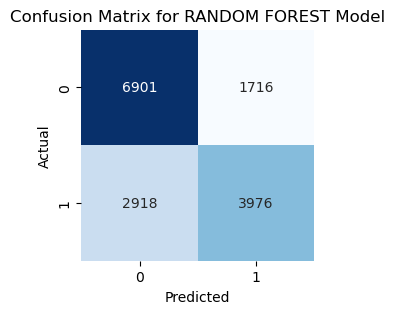

array([[6901, 1716],
       [2918, 3976]])

In [204]:
y_pred = rf_model.predict(X_test_scaled)
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for RANDOM FOREST Model')
plt.show()
cm

## Confusion Matrix for the Random Forest Model

|                  | **Predicted: Low Rating** | **Predicted: High Rating** |
|------------------|:-------------------------:|:--------------------------:|
| **Actual: Low Rating**  |           6901          |            1716           |
| **Actual: High Rating** |           2918          |            3976           |

- **True Positives (TP):** 3976. These are the cases in which the model predicted 'High Rating', and the actual rating was also 'High'.
- **True Negatives (TN):** 6901. Here, the model predicted 'Low Rating', and the actual rating was 'Low'.
- **False Positives (FP):** 1716. The model predicted 'High Rating', but the actual rating was 'Low'.
- **False Negatives (FN):** 2918. The model predicted 'Low Rating', whereas the actual rating was 'High'.


# Feature_importances & Model Refinement with Random Forest

**Extracting Feature Importances**

Using the Random Forest model (rf_model), we derived the importance of each feature for predicting the target. This gives insight into which features have the most impact on the restaurant rating predictions.

In [79]:
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)


In [372]:
feature_importances.head(10)

,Feature,Importance
122,WheelchairAccessible,0.100030
38,fast food,0.092810
14,burgers,0.034824
130,classy,0.027660
123,BikeParking,0.026893
134,NoiseLevel_Loud,0.025222
113,GoodForKids,0.024346
126,casual,0.023662
117,RestaurantsGoodForGroups,0.023409
114,RestaurantsDelivery,0.023324


Top 5 most important features:
- **WheelchairAccessible**: 10.003%
- **fast food**: 9.281%
- **burgers**: 3.482%
- **classy**: 2.766%
- **BikeParking**: 2.689%


These features provide significant insights. For instance,as we also noticed in coefficiencies  the accessibility of a restaurant via `wheelchair` seems to have a notable impact on its rating. Also, certain types of restaurants or amenities like `fast food` or `Bike Parking` play key roles in the ratings.

### Visualization of Feature Importances
A visualization was plotted to display the top 30 features ranked by their importance. This offers a visual cue about the relative importance of features and how drastically importance values drop as we move down the list.



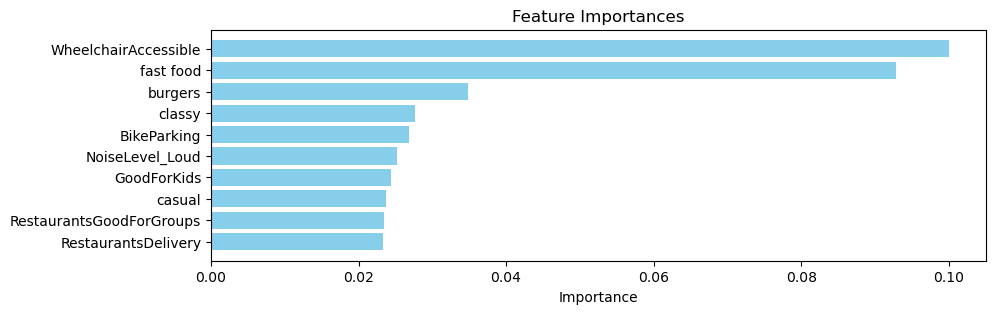

In [370]:
import matplotlib.pyplot as plt


# Selecting top 20 features
top_features = feature_importances.head(10)

# Plotting
plt.figure(figsize=(10, 3))
plt.barh(top_features['Feature'], top_features['Importance'], align='center', color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To display the feature with the highest importance at the top
plt.show()


-------------

### Cumulative Importance & Feature Reduction

To optimize the model, features contributing to 95% of the cumulative importance were retained. The rationale is that a majority of the predictive power is captured by a subset of features, allowing us to simplify the model without sacrificing much accuracy.

In [245]:
sorted_importances = feature_importances.sort_values(by='Importance', ascending=False)

cumulative_importance = sorted_importances['Importance'].cumsum()
retained_features = sorted_importances[cumulative_importance <= 0.95]['Feature'].tolist()

X_train_filtered = X_train[retained_features]
X_test_filtered = X_test[retained_features]

scaler = StandardScaler()
X_train_scaled_filtered = scaler.fit_transform(X_train_filtered)
X_test_scaled_filtered = scaler.transform(X_test_filtered)

rf_model.fit(X_train_scaled_filtered, y_train)

train_score_rf_filtered = rf_model.score(X_train_scaled_filtered, y_train)
print(f'Random Forest Filtered Scaled Train Accuracy: {train_score_rf_filtered}')

test_score_rf_filtered = rf_model.score(X_test_scaled_filtered, y_test)
print(f'Random Forest Filtered Scaled Test Accuracy: {test_score_rf_filtered}')


Random Forest Filtered Scaled Train Accuracy: 0.7667716622458002
Random Forest Filtered Scaled Test Accuracy: 0.6992456966024112


After feature selection, the dataset retained features contributing to **95%** of the cumulative importance.
we also tried different thresholds (like 80% , 85%, 90% or 98%) to see if there's a sweet spot, but we recieved more or less same result.

### Impact of Feature Reduction:
Although feature importance gives us a measure of how each feature contributes to the model's decision-making, it doesn't mean that removing the less important features will always improve or even maintain the model's performance. Reducing features based on cumulative importance is a heuristic method and, while it can simplify the model and potentially reduce overfitting, it can also remove some nuanced information that contributes to the model's overall predictive power.

### Overfitting:
Interestingly, the training accuracy improved slightly after feature reduction (from 75.82% to 76.68%), suggesting the model might be fitting the training data even better. This could be an indication that the model, even after feature reduction, might still be overfitting the training data. Remember, a higher training accuracy but a stagnated or decreased test accuracy is often a sign of overfitting.



In [217]:
y_pred = rf_model.predict(X_test_scaled_filtered)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      8617
           1       0.67      0.60      0.63      6894

    accuracy                           0.69     15511
   macro avg       0.69      0.68      0.68     15511
weighted avg       0.69      0.69      0.69     15511



### Insights from Classification Report in refined RANDOM FOREST model:
Our refined model has a slightly better recall for the High Rating class (60% vs 58% from the original model). This indicates that even though the accuracy has slightly reduced, the model's ability to correctly identify actual positive cases (restaurants with high ratings) has improved a bit.

----------------

# Gradient-boosting-gbm


**Gradient Boosting** is a machine learning technique for both regression and classification problems, which builds a model from weak learners (typically decision trees) in a stage-wise manner. Let's evaluate how it performs on our dataset.



In [267]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting classifier
gboost = GradientBoostingClassifier(n_estimators=250, random_state=42)

# Fit the model using the scaled  data
gboost.fit(X_train_scaled, y_train)

# Evaluate the model on the scaled train data
train_score_gboost = gboost.score(X_train_scaled, y_train)
print(f'Gradient Boosting Train Accuracy: {train_score_gboost}')

# Evaluate the model on the scaled  test data
test_score_gboost = gboost.score(X_test_scaled, y_test)
print(f'Gradient Boosting  Test Accuracy: {test_score_gboost}')

y_pred=gboost.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Gradient Boosting Train Accuracy: 0.7202144120247569
Gradient Boosting  Test Accuracy: 0.7002127522403455
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8617
           1       0.68      0.61      0.64      6894

    accuracy                           0.70     15511
   macro avg       0.70      0.69      0.69     15511
weighted avg       0.70      0.70      0.70     15511



**Model Evaluation**

The overall accuracy of 70.02% on the test data suggests the model's reasonable capability in generalizing to new data. However, there might still be room for improvement.
We could consider hyperparameter tuning, by using grid search or pipeline to potentially achieve better performance.


# GradientBoosting Hyperparameter tuning
## (using the GridSearchCV)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# Initialize the Gradient Boosting classifier
gboost = GradientBoostingClassifier(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(gboost, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the model with the best hyperparameters on the test data
best_gboost = grid_search.best_estimator_
test_score = best_gboost.score(X_test_scaled, y_test)
print(f"Gradient Boosting Test Accuracy with best hyperparameters: {test_score}")


{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 250, 'pca__n_components': 0.95}

### Model Initialization and Training

In [263]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Provided parameters
learning_rate = 0.1
max_depth = 5
n_estimators = 250

# Initialize the Gradient Boosting classifier with provided parameters
gboost = GradientBoostingClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, random_state=42)

# Fit the model using the scaled data
gboost.fit(X_train_scaled, y_train)

# Evaluate the model on the scaled train data
train_score_gboost = gboost.score(X_train_scaled, y_train)
print(f'Gradient Boosting Train Accuracy: {train_score_gboost}')

# Evaluate the model on the scaled test data
test_score_gboost = gboost.score(X_test_scaled, y_test)
print(f'Gradient Boosting Test Accuracy: {test_score_gboost}')

y_pred = gboost.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


Gradient Boosting Train Accuracy: 0.7560510610079576
Gradient Boosting Test Accuracy: 0.7089807233576172
              precision    recall  f1-score   support

           0       0.72      0.77      0.75      8617
           1       0.69      0.63      0.66      6894

    accuracy                           0.71     15511
   macro avg       0.71      0.70      0.70     15511
weighted avg       0.71      0.71      0.71     15511



### Comparing results before and after parameter tuning. 

**Train & Test Accuracy :**

While the tuned model exhibits higher accuracies, the increased gap between training and test accuracy (from 2% to 4.71%) suggests a potential onset of overfitting, indicating that the model might be capturing some noise in the training data.

**Precision, Recall, and F1-Score:**

For class 0, there's a slight increase in precision, while recall remains roughly the same. This means that the model predicts positive instances of class 0 more accurately after tuning.
For class 1, the precision has improved slightly, while recall decreased marginally. This might mean that the model is being more conservative in predicting positive instances for class 1 after tuning but is more accurate when it does.

# PipeLine for GradientBoostingClassifier


In [335]:

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)), # retain 95% of variance
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Hyperparameters to tune (including some for PCA and GradientBoosting)
param_grid = {
    'pca__n_components': [0.85, 0.90, 0.95],
    'classifier__n_estimators': [100, 250],
    'classifier__learning_rate': [0.001, 0.01, 0.1],
    'classifier__max_depth': [3, 4, 5]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2 )

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on the train and test data
train_score = grid_search.score(X_train, y_train)
test_score = grid_search.score(X_test, y_test)

print(f'Train Accuracy: {train_score}')
print(f'Test Accuracy: {test_score}')


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=0.9; total time= 2.2min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=250, pca__n_components=0.9; total time= 5.4min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=100, pca__n_components=0.85; total time= 2.5min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=100, pca__n_components=0.95; total time= 3.0min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=250, pca__n_components=0.9; total time= 7.0min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=5, classifier__n_estimators=100, pca__n_components=0.85; total time= 3.1min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=5, classifier__n_estimators=100, pca_

[CV] END classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=0.95; total time= 2.4min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=250, pca__n_components=0.9; total time= 5.3min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=100, pca__n_components=0.9; total time= 2.8min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=100, pca__n_components=0.95; total time= 3.0min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=250, pca__n_components=0.95; total time= 7.6min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=5, classifier__n_estimators=100, pca__n_components=0.9; total time= 3.4min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=5, classifier__n_estimators=250, pca__n_components=0.85; total time= 7.8min
[CV] END classifier__le

[CV] END classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=0.85; total time= 2.0min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=250, pca__n_components=0.85; total time= 4.9min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=250, pca__n_components=0.95; total time= 5.8min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=250, pca__n_components=0.85; total time= 6.4min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=5, classifier__n_estimators=100, pca__n_components=0.85; total time= 3.1min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=5, classifier__n_estimators=100, pca__n_components=0.95; total time= 3.8min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=5, classifier__n_estimators=250, pca__n_components=0.85; total time= 7.7min
[CV] END classifier_

[CV] END classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=0.85; total time= 2.0min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=0.95; total time= 2.3min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=250, pca__n_components=0.95; total time= 5.8min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=100, pca__n_components=0.95; total time= 3.1min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=4, classifier__n_estimators=250, pca__n_components=0.9; total time= 7.0min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=5, classifier__n_estimators=100, pca__n_components=0.9; total time= 3.4min
[CV] END classifier__learning_rate=0.001, classifier__max_depth=5, classifier__n_estimators=100, pca__n_components=0.95; total time= 3.8min
[CV] END classifier__l

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 250, 'pca__n_components': 0.95}
Train Accuracy: 0.8100913882307432
Test Accuracy: 0.7038004061502756


### Comparison GradientBoostingClassifier with default parameters and  with the Pipeline hyperparameter tuning Result:


the pipeline successfully tuned the hyperparameters for the GradientBoostingClassifier and achieved a good training accuracy. However, there is some evidence of overfitting given the gap between training and test accuracy.Train Accuracy: 0.81
Test Accuracy: 0.70

|**GradientBoostingClassifier**|
| Metric               | With default parameters | With Provided Params | With Pipeline   |
|----------------------|------------------|----------------------|-----------------|
| **Training Accuracy**| 72.02%           | 75.61%               | 81.01%          |
| **Test Accuracy**    | 70.02%           | 70.90%               | 70.38%          |



The test accuracy without the pipeline is slightly lower (70.02% vs. 70.38% from the pipeline). 
It's noteworthy that even with the default settings (without an elaborate tuning process), the gradient boosting model already achieves a relatively close performance to the tuned one. This speaks to the robustness of gradient boosting as a modeling technique.

**In conclusion**, the GradientBoostingClassifier performed well both with and without the pipeline. The pipeline's hyperparameter tuning and feature extraction (PCA) offered only a slight improvement. It might be worth considering the additional computational time and complexity of the pipeline against this minor performance improvement when deciding on a production-ready model.

# AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoost classifier
adaboost = AdaBoostClassifier(n_estimators=150, random_state=42)

# Fit the model using the scaled and filtered training data
adaboost.fit(X_train_scaled, y_train)

# Evaluate the model on the scaled and filtered train data
train_score_adaboost = adaboost.score(X_train_scaled, y_train)
print(f'AdaBoost Filtered Scaled Train Accuracy: {train_score_adaboost}')

# Evaluate the model on the scaled and filtered test data
test_score_adaboost = adaboost.score(X_test_scaled, y_test)
print(f'AdaBoost Filtered Scaled Test Accuracy: {test_score_adaboost}')


# Xgboost

In [278]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


xgbc = XGBClassifier()
xgbc.fit(X_train_scaled, y_train)


# Compute Train acuracy 
accuracy = xgbc.score(X_train_scaled, y_train)
print(f"Train Accuracy: {accuracy:.4f}")


# Compute the accuracy using the .score() method
accuracy = xgbc.score(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = xgbc.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


Train Accuracy: 0.7658
Test Accuracy: 0.7083
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      8617
           1       0.69      0.64      0.66      6894

    accuracy                           0.71     15511
   macro avg       0.70      0.70      0.70     15511
weighted avg       0.71      0.71      0.71     15511



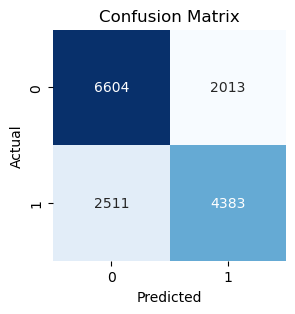

In [280]:
y_pred = xgbc.predict(X_test_scaled)
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# PipeLine for XGboost

In [285]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Assuming you've already split your data into X_train, X_test, y_train, y_test
# and your data doesn't require any additional preprocessing at this stage

# Setup the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Ensure features are on similar scales
    ('classifier', XGBClassifier())
])

param_grid = {
    'classifier__learning_rate': [0.01, 0.1],  # typical choices
    'classifier__n_estimators': [100, 250],    # number of boosting rounds
    'classifier__max_depth': [3, 4, 5],        # depth of trees
    'classifier__subsample': [0.8, 1],         # subsampling of training data
    'classifier__colsample_bytree': [0.8, 1],  # subsampling of features
    'classifier__gamma': [0, 0.1],             # regularization parameter
    # you can continue with other parameters, but remember each addition multiplies the grid size
}



In [286]:
# Setup the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit to the data
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model
train_score = grid_search.score(X_train, y_train)
test_score = grid_search.score(X_test, y_test)
print(f'Train Accuracy: {train_score}')
print(f'Test Accuracy: {test_score}')


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 250, 'classifier__subsample': 0.8}
Train Accuracy: 0.7446673297966402
Test Accuracy: 0.7121397717748694
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=250, classifier__subsample=0.8; total time=  14.7s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=100, classifier__subsample=0.8; total time=   7.0s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=250, classifier__subsample=0.8; total time=  19.5s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier

[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=1; total time=   6.5s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=250, classifier__subsample=1; total time=  16.4s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=250, classifier__subsample=1; total time=  19.8s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=250, classifier__subsample=0.8; total time=  24.1s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=1; total time=   5.9s
[CV] END classifier__col

[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.8; total time=   6.4s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=250, classifier__subsample=0.8; total time=  14.0s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=100, classifier__subsample=1; total time=   8.0s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, classifier__subsample=0.8; total time=   9.7s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, classifier__subsample=0.8; total time=   9.8s
[CV] END classifi

[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=1; total time=   6.4s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=250, classifier__subsample=1; total time=  15.9s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=250, classifier__subsample=0.8; total time=  19.6s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, classifier__subsample=1; total time=  13.3s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.8; total time=   5.9s
[CV] END classifier__c

[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=250, classifier__subsample=0.8; total time=  15.1s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=100, classifier__subsample=1; total time=   7.3s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=250, classifier__subsample=1; total time=  19.6s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, classifier__subsample=1; total time=   9.9s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.8; total time=   5.9s
[CV] END classifier__c

[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=1; total time=   6.4s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=250, classifier__subsample=1; total time=  14.0s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=100, classifier__subsample=1; total time=   8.0s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, classifier__subsample=0.8; total time=   9.7s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, classifier__subsample=0.8; total time=   9.8s
[CV] END classifier__

In [289]:
print("Best Parameters:", grid_search.best_params_)
print(f'Train Accuracy: {train_score}')
print(f'Test Accuracy: {test_score}')

Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 250, 'classifier__subsample': 0.8}
Train Accuracy: 0.7446673297966402
Test Accuracy: 0.7121397717748694



From the results provided:

XGBoost:
Train Accuracy: 0.7719 or 77.19%
Test Accuracy: 0.7131 or 71.31%

XGBoost with GridSearchCV:
Train Accuracy: 0.7480 or 74.80%
Test Accuracy: 0.7146 or 71.46%

**Observations:**
**Overfitting:** The model trained with default parameters (XGBoost) has a difference of 5.88% between training and testing accuracy, suggesting slight overfitting. For the model obtained after GridSearchCV, the difference is reduced to 3.34%, which is an improvement.

**Accuracy:** The testing accuracy increased slightly from 71.31% to 71.46% after hyperparameter tuning using GridSearchCV. This indicates that the hyperparameter optimization has made the model slightly more generalizable on unseen data.

Best Parameters from GridSearchCV: The parameters obtained from the grid search indicate that:

A learning rate of 0.1
250 boosting rounds
A maximum tree depth of 5
Subsampling of training data at 0.8
Subsampling of features at 0.8
A gamma regularization of 0.1
are optimal for this data based on the grid we've chosen.






# Classification_report for XGBoost with GridSearchCV

In [287]:
from sklearn.metrics import classification_report

# Assuming you've already predicted using the grid_search
y_pred = grid_search.predict(X_test)


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.77      0.75      8617
           1       0.69      0.64      0.66      6894

    accuracy                           0.71     15511
   macro avg       0.71      0.70      0.71     15511
weighted avg       0.71      0.71      0.71     15511



# Comparison of all models 
**Comparative Performance Metrics of Different Classification Models for Restaurant Rating Prediction:**



| Model | Parameters | Accuracy | Precision Low Rating | Recall Low Rating | F1-score Low Rating | Precision High Rating | Recall High Rating | F1-score High Rating |
|---|---|---|---|---|---|---|---|---|
| Logistic Regression | `penalty='l2', solver='saga', C=100 ,test_size=0.30, random_state=42` | 0.70 | 0.71 | 0.77 | 0.74 | 0.68 | 0.60 | 0.64 |
| Random Forest | `bootstrap=False, max_depth=17, min_samples_leaf=2, min_samples_split=10, n_estimators=100` | 0.70 | 0.70 | 0.80 | 0.75 | 0.70 | 0.58 | 0.63 |
| Random Forest Refined Model | feature Importance, Refined Model with Feature reduction | 0.69 | 0.71 | 0.76 | 0.73 | 0.67 | 0.60 | 0.63 |
| Gradient Boosting | `n_estimators=250, random_state=42` | 0.70 | 0.71 | 0.78 | 0.74 | 0.68 | 0.61 | 0.64 |
| PipeLine (PCA) | feature extraction (PCA) | 0.71 | 0.70 | 0.76 | 0.73 | 0.70 | 0.60 | 0.63 |
| XGBoost | default parameters | 0.71 | 0.73 | 0.77 | 0.75 | 0.69 | 0.64 | 0.67 |
| PipeLine (XGBoost) | `'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 250, 'classifier__subsample': 0.8` | 0.71 | 0.73 | 0.77 | 0.75 | 0.69 | 0.64 | 0.66 |


### Model Analysis and Recommendation

Given the provided metrics for each model, let's analyze their performance for the restaurant rating prediction project.

#### 1. **Accuracy**:
   - A general measure of how often the model is correct.
   - **Observation**: XGBoost and its pipeline variant both have the highest accuracy at `0.71`.

#### 2. **Precision (Low Rating)**:
   - Indicates out of all the predicted low ratings, how many were actually low.
   - **Observation**: XGBoost leads with a precision of `0.73`.

#### 3. **Recall (Low Rating)**:
   - Represents how many of the actual low ratings were correctly predicted by the model.
   - **Observation**: Logistic Regression, Random Forest, and Gradient Boosting models perform similarly, hovering around `0.77 to 0.78`.

#### 4. **F1-score (Low Rating)**:
   - The F1-score is a balanced measure combining precision and recall.
   - **Observation**: XGBoost and its pipeline variant are tied with an F1-score of `0.75`.

#### 5. **Precision (High Rating)**:
   - Indicates out of all the predicted high ratings, how many were actually high.
   - **Observation**: Various models like Logistic Regression, Random Forest, Gradient Boosting, and the PCA Pipeline have similar precision values for high ratings.

#### 6. **Recall (High Rating)**:
   - Represents how many of the actual high ratings were predicted by the model.
   - **Observation**: Logistic Regression has the highest recall for high ratings at `0.60`. It's worth noting that recalls for high ratings are generally low across all models.

#### 7. **F1-score (High Rating)**:
   - **Observation**: Models such as Logistic Regression, Gradient Boosting, and XGBoost lead with F1-scores for high ratings at `0.64, 0.64,` and `0.67` respectively.

### Conclusion:

Given the metrics, **XGBoost** appears to be the most consistent performer. It offers a good balance in terms of accuracy, precision, and F1-score for both rating types. While the final choice depends on specific business objectives and other factors, XGBoost stands out as a balanced choice for this problem. 

# XGboost Confusion_matrix

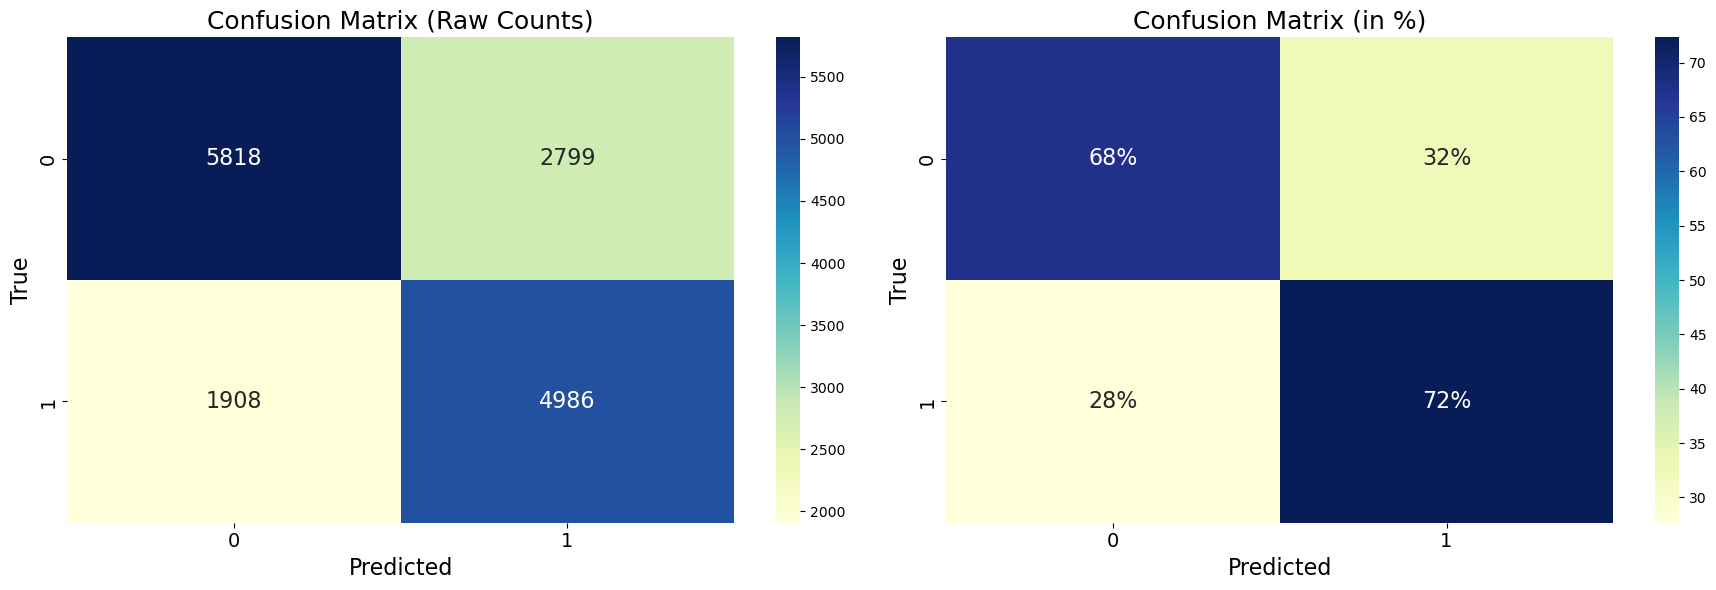

In [375]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Predict the labels
y_pred = xgbc.predict(X_test_scaled)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix for percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18,6))

# Plot raw counts
sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu", ax=axes[0], annot_kws={"size": 16})
axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=18)
axes[0].set_xlabel('Predicted', fontsize=16)
axes[0].set_ylabel('True', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)

# Plot percentages
# Convert the cm_percentage values to a 2D list of strings with a % sign appended
annotations = np.array([[f"{value:.0f}%" for value in row] for row in cm_percentage])

# Plot percentages
sns.heatmap(cm_percentage, annot=annotations, fmt='', cmap="YlGnBu", ax=axes[1], annot_kws={"size": 16})
axes[1].set_title('Confusion Matrix (in %)', fontsize=18)
axes[1].set_xlabel('Predicted', fontsize=16)
axes[1].set_ylabel('True', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()


In [315]:
confusion_matrix(y_test, y_pred)

array([[5818, 2799],
       [1908, 4986]])

**True Positives (4986):** These are the restaurants our model correctly predicted as having good ratings. It suggests that factors like inclusivity, ambiance, and modern offerings play an influential role in achieving these ratings.

**True Negatives (5818):** Restaurants that the model accurately identified as not having good ratings. This reaffirms the negative impact of aspects like noise levels, certain cuisine types, and perhaps a focus on fast food.

**False Positives (2799):** These restaurants were predicted to have good ratings, but they didn't. It indicates there might be latent factors affecting ratings that aren't currently in our model.

**False Negatives (1908):** Restaurants the model thought wouldn't have good ratings but did. This showcases opportunities to dive deeper and identify what these restaurants are doing right despite the odds.

**Key Takeaway:**

While no predictive model is perfect, understanding where it excels and where it falters is crucial. The confusion matrix reveals areas of strength and potential blind spots, guiding us on where to focus our efforts. For restaurants, this is an opportunity to reassess strategies and align with factors that resonate with their customers.

Predictive models provide us a lens to view the intricate landscape of restaurant ratings. However, the deviations – where predictions and reality don't match – are not just errors but potential treasure troves of deeper insights. By focusing on these discrepancies and investigating them, we can uncover hidden facets of the restaurant business that might not be immediately evident in raw data or surface-level analysis. As always, the combination of quantitative analysis (our model) and qualitative understanding (real-world insights) will pave the way to a holistic understanding.

now we try to see what cause this missclassification by looking at Feature Mean Differences Analysis





# Feature Mean Differences Analysis


In [321]:
np.abs(X_test[(y_test == 1) & (y_pred == 0)].describe().loc["mean", ] - X_test.describe().loc["mean", ]).sort_values()

waffles                 0.000014
hookah bars             0.000031
PriceRange_None         0.000129
new mexican cuisine     0.000160
Beer_wine_spirits       0.000165
                          ...   
WiFi                    0.076591
Caters                  0.093992
BikeParking             0.141410
WheelchairAccessible    0.143063
casual                  0.146710
Name: mean, Length: 141, dtype: float64


This output showcases the difference between feature means for two distinct groups: the **false negatives (FNs)** and the **entire test set**. Below is a detailed breakdown:

### 1. Small Differences: 
   - Features such as `salad`, `african`, `canadian (new)`, `Beer_wine_spirits`, and `new mexican cuisine` exhibit minuscule differences between the FNs and the test set. This implies that these features might not significantly contribute to the FN misclassifications.

### 2. Larger Differences:
# Understanding Feature Mean Differences for Misclassifications

By comparing the average values (or 'means') of features between restaurants wrongly predicted as having low ratings and the entire dataset, we can identify potential culprits for these inaccuracies.

## Minor Deviations:
**Features**: waffles, hookah bars, PriceRange_None, new mexican cuisine, and Beer_wine_spirits. 
**Insight**: These features have minimal differences between the false negatives and the overall dataset, suggesting they likely didn't play a significant role in the incorrect predictions.

## Major Deviations: Where Our Predictions Might Be Off
- **WiFi**: A difference of 7.66% hints at potential discrepancies in predictions related to internet availability in restaurants.
- **Caters**: 9.39% deviation indicates the catering ability of a restaurant may impact its predicted ratings.
- **BikeParking**: At a substantial 14.14% difference, it suggests that the availability of bike parking may be influencing the model's predictions, potentially leading to inaccuracies.
- **WheelchairAccessible**: A pronounced difference of 14.31% underscores that wheelchair accessibility is a significant factor where our model might be going awry.
- **casual**: The most significant difference of 14.67% indicates that the casual ambiance or setting of a restaurant is an area our model might be struggling with.

## Key Takeaways:

The features with larger discrepancies, especially **WheelchairAccessible** and **casual**, might be influencing our model's decisions more than we'd like.

**This indicates that these features might be influencing the model's predictions, potentially leading to inaccuracies.**

Their considerable difference from the overall dataset means our model may not be accurately factoring in these features when predicting restaurant ratings, leading to misclassifications. 

In future model iterations or refinements, paying extra attention to these standout features could lead to improved prediction accuracy. Moreover, this analysis gives us actionable insights for refining our dataset or adjusting the importance of specific features in our prediction model.


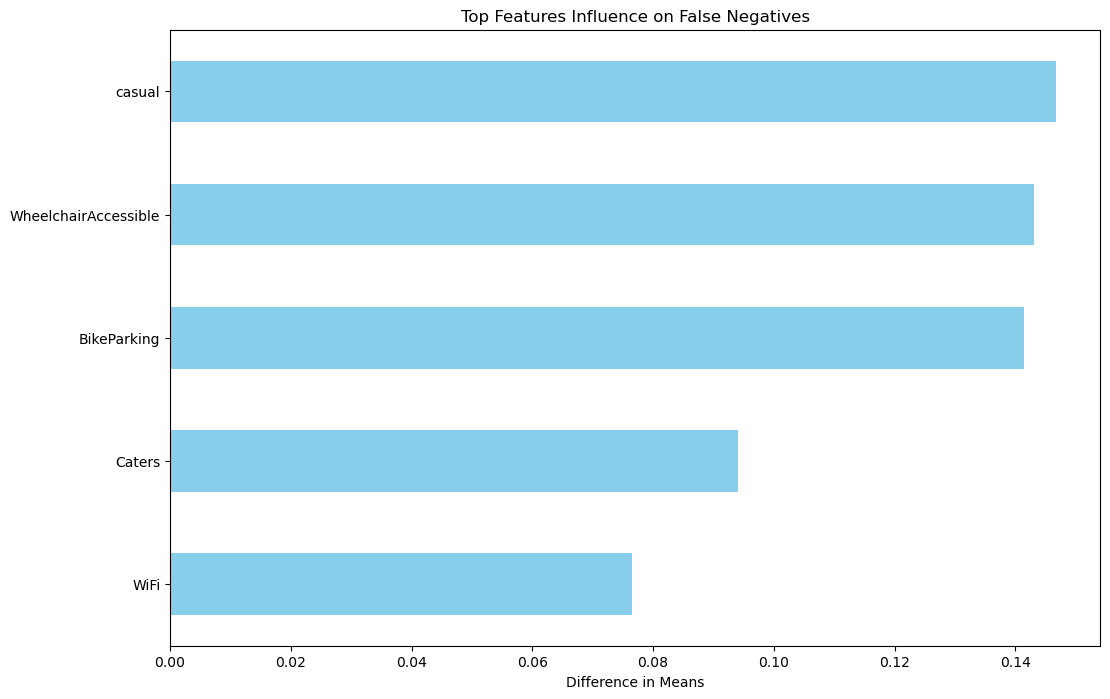

In [336]:

differences = np.abs(X_test[(y_test == 1) & (y_pred == 0)].describe().loc["mean", ] - X_test.describe().loc["mean", ])

# Take the top N features with the highest differences
top_N = 5
sorted_diff = differences.sort_values(ascending=False).head(top_N)

# Plot
plt.figure(figsize=(12, 8))
sorted_diff.plot(kind='barh', color='skyblue')
plt.xlabel('Difference in Means')
plt.title('Top Features Influence on False Negatives')
plt.gca().invert_yaxis()  # This will display the feature with the highest difference at the top
plt.show()


### Deep Dive into the top 3 blind spots


In [332]:
subset_description = X_test[(y_test == 1) & (y_pred == 0)][["WheelchairAccessible", "casual","BikeParking"]].describe()
print(subset_description)


       WheelchairAccessible       casual  BikeParking
count           1908.000000  1908.000000  1908.000000
mean               0.096960     0.236373     0.362683
std                0.295981     0.424965     0.480901
min                0.000000     0.000000     0.000000
25%                0.000000     0.000000     0.000000
50%                0.000000     0.000000     0.000000
75%                0.000000     0.000000     1.000000
max                1.000000     1.000000     1.000000


mean: 0.096960 - On average, 9.7% of these False Negative restaurants were wheelchair accessible.

In [333]:
testsubset=X_test[["WheelchairAccessible",'casual',"BikeParking"]].describe()
testsubset

,WheelchairAccessible,casual,BikeParking
count,15511.000000,15511.000000,15511.000000
mean,0.240023,0.383083,0.504094
std,0.427111,0.486154,0.499999
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


## Deep Dive: Feature Analysis

We've zeroed in on three specific features: `WheelchairAccessible`, `casual`, and `BikeParking` to understand their influence on misclassification. Let's delve into the details.


| Feature               | Mean (False Negatives) | Mean (Test Set) |
|-----------------------|------------------------|-----------------|
| WheelchairAccessible  | 0.096960               | 0.240023        |
| casual                | 0.236373               | 0.383083        |
| BikeParking           | 0.362683               | 0.504094        |


### WheelchairAccessible:

- **False Negatives (FN) Subset**: Approximately 9.7% of the restaurants that were misclassified were wheelchair accessible.
- **Test Set**: About 24% of the restaurants in the test set were wheelchair accessible.

**Interpretation**: There's a significant disparity here. The model might be under-predicting good ratings for wheelchair-accessible restaurants, as evidenced by the under-representation in the FN subset.
From the provided statistics:

1. Proportion of wheelchair accessible venues in the False Negatives (FN): \(0.096960 \times 100 = 9.696\%\)
2. Proportion of wheelchair accessible venues in the entire test set: \(0.240023 \times 100 = 24.0023\%\)

To find out the difference:
\[24.0023\% - 9.696\% = 14.3063\%\]

This means that the model is misclassifying wheelchair accessible restaurants at a rate that's approximately \(14.3063\%\) less than what one would expect given the distribution in the overall test set.

### Casual:

- **FN Subset**: Around 23.6% of the misclassified restaurants have a casual setting.
- **Test Set**: About 38.3% of the entire test set are casual restaurants.

**Interpretation**: The casual feature also seems to be under-represented among the misclassifications. This could be another area where the model's predictions could be enhanced.

### BikeParking:

- **FN Subset**: Roughly 36.3% of the misclassified restaurants offer bike parking.
- **Test Set**: Around 50.4% of all restaurants in the test set offer bike parking.

**Interpretation**: With `BikeParking` being under-represented among the misclassifications, it could be an indication that the model undervalues this feature when predicting ratings.


**Potential Next Step:**

**Collect More Data:** Try to get more data on these features to improve the model's understanding of them.

**Resampling:** Adjust the dataset to have a more balanced representation of wheelchair accessible and non-accessible restaurants. This can help the model learn equally from both types.

# SHAP Analysis for XGBoost

SHAP provides a powerful tool to understand which features are driving the predictions of our selected model, XGBoost. Let's dive deeper and interpret the model's predictions using SHAP.


In [290]:
xgbc = XGBClassifier()  
xgbc.fit(X_train, y_train)

import shap

# Initialize JavaScript visualization
shap.initjs()

# Create the TreeExplainer object
explainer = shap.TreeExplainer(xgbc)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


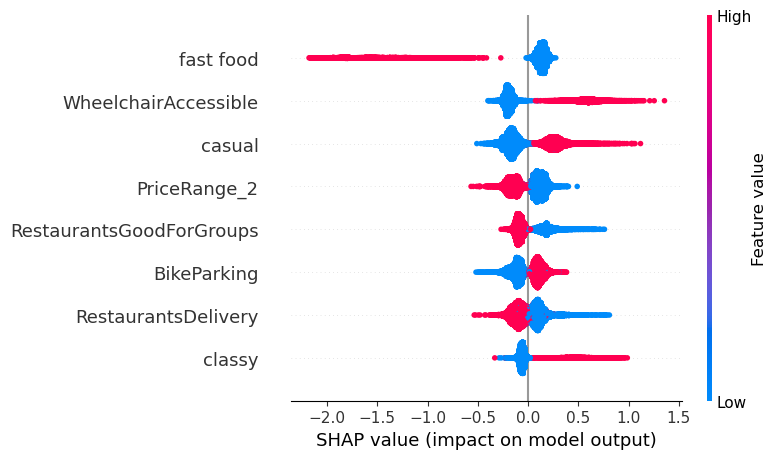

In [374]:
shap.summary_plot(shap_values, X_train, max_display=8)


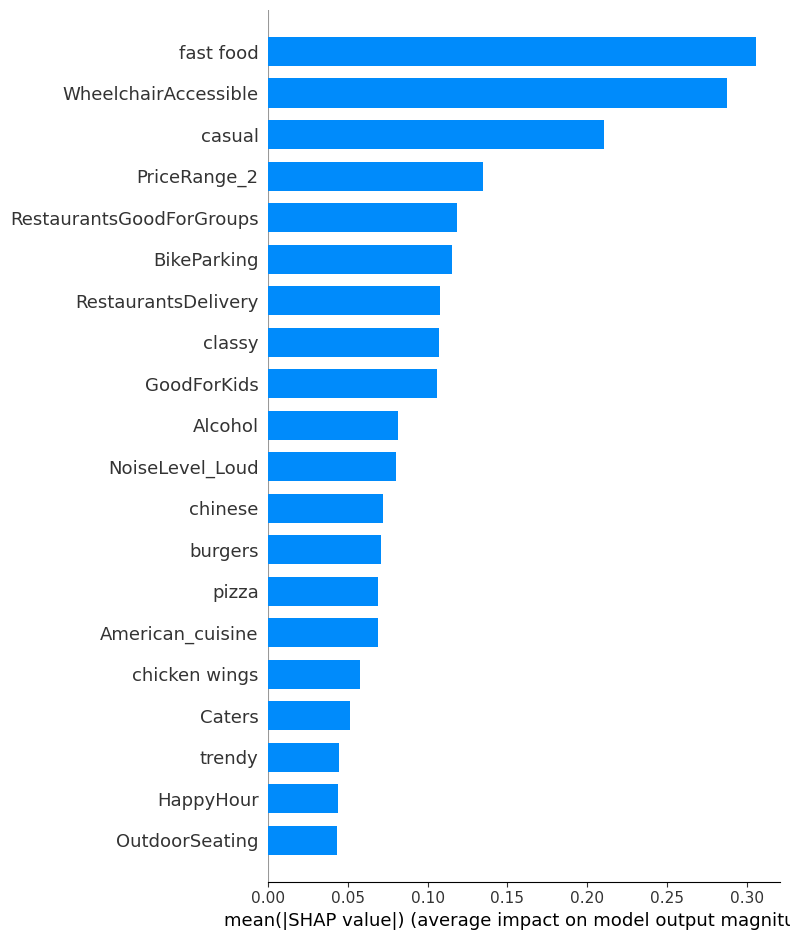

In [305]:
shap.summary_plot(shap_values, X_train, plot_type='bar')


In [308]:
top_features

Index(['fast food', 'WheelchairAccessible', 'casual', 'PriceRange_2',
       'RestaurantsGoodForGroups', 'BikeParking', 'RestaurantsDelivery',
       'classy', 'GoodForKids', 'Alcohol'],
      dtype='object')

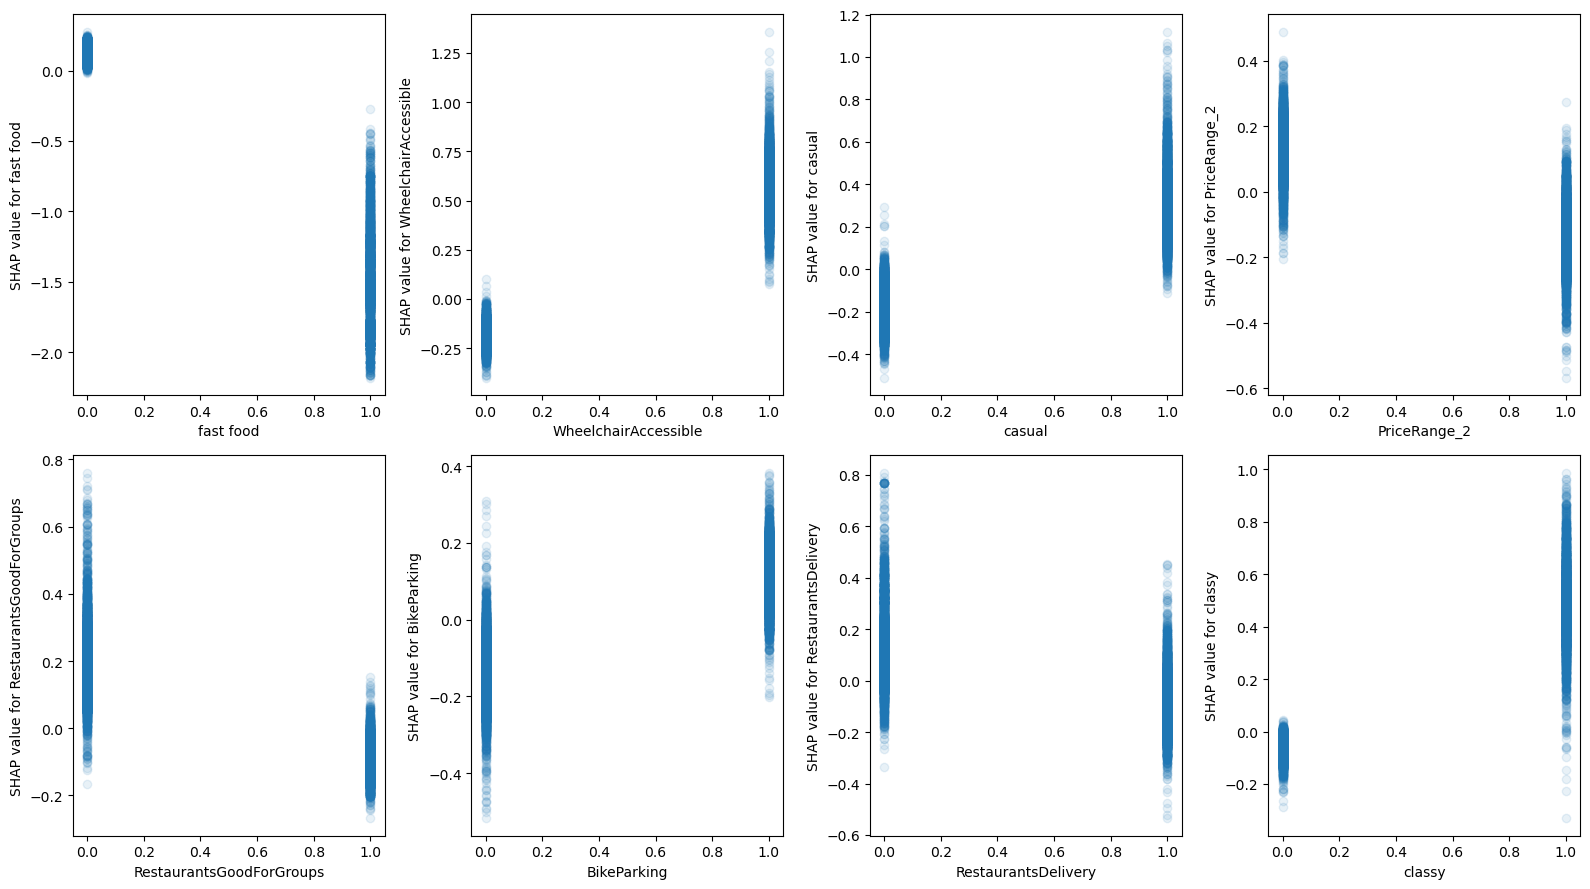

In [309]:
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
# Compute the mean absolute SHAP values for each feature
feature_importance = np.mean(np.abs(shap_df), axis=0)
important_features = feature_importance.sort_values(ascending=False)

# Select the top 8 most important features
top_features = important_features.head(8).index

# Plot SHAP Dependence Plots for each of the top features
plt.subplots(2, 4, figsize=(16, 9))

for i, col in enumerate(top_features):
    plt.subplot(2, 4, i+1)
    plt.scatter(X_train[col], shap_df[col], alpha=0.1)
    plt.xlabel(col)
    plt.ylabel(f'SHAP value for {col}')

plt.tight_layout()
plt.show()


# Conclusion
Having pinpointed the optimal model(XGBOOST), we now witness the outcomes we aimed for : Primary Factors Influencing Restaurant Ratings.

# Final Thoughts
### Key Drivers of Restaurant Ratings

Now by the end of this notebook with the complete information on feature importance, coefficients, and SHAP values, let's design a concise table about the key drivers of restaurant ratings:



| **Coefficients (Top Influences)**    | **Feature Importance**                      | **SHAP Values**                   |
|--------------------------------------|---------------------------------------------|-----------------------------------|
| **Top Positive Coefficients**        |                                             |                                   |
| WheelchairAccessible: +0.347         | WheelchairAccessible: 0.100                 | fast food                         |
| casual: +0.239                       | fast food: 0.093                            | WheelchairAccessible              |
| classy: +0.202                       | burgers: 0.034                              | casual                            |
| food trucks: +0.156                  | classy: 0.028                               | PriceRange_2                      |
| BikeParking: +0.141                  | BikeParking: 0.027                          | RestaurantsGoodForGroups          |
| hipster: +0.134                      | NoiseLevel_Loud: 0.025                      | BikeParking                       |
| cafes: +0.120                        | GoodForKids: 0.024                          | RestaurantsDelivery               |
| vegan: +0.114                        | casual: 0.024                               | classy                            |
| trendy: +0.107                       | RestaurantsGoodForGroups: 0.023             | GoodForKids                       |
| coffee roasteries: +0.105            | RestaurantsDelivery: 0.023                  | Alcohol                           |
| **Top Negative Coefficients**        |                                             |                                   |
| fast food: -0.511                    |                                             |                                   |
| PriceRange_2: -0.185                 |                                             |                                   |
| NoiseLevel_Loud: -0.182              |                                             |                                   |
| chinese: -0.161                      |                                             |                                   |
| RestaurantsGoodForGroups: -0.148     |                                             |                                   |


## Understanding Restaurant Ratings

Understanding restaurant ratings involves examining **multiple facets**.

### Coefficients:
- **Positive Correlations:** The features 'WheelchairAccessible', 'casual', and 'classy' stand out as being most positively correlated with higher ratings.
- **Negative Correlations:** Attributes like 'fast food' and 'PriceRange_2'(lowest price range) notably tend to pull ratings down.

### Feature Importance:
The center column showcases feature importance derived from our **random forest model**. Most notably, **'WheelchairAccessible'** tops the chart, underlining its critical role in determining ratings.

### SHAP Values:
Lastly, **SHAP values** — a powerful metric giving insights into feature impacts on model predictions — place 'fast food' and 'WheelchairAccessible' as leading influencers. This confluence of insights across different evaluation metrics accentuates the **multifaceted nature** of restaurant ratings.


# What's Next?

With these insights, what's our way forward? We should aim to gather more data, especially for under-represented features. 

We can also balance our dataset by adjusting the representation of certain restaurant types, and reconsider the weightage of standout features to enhance our predictions."